In [1]:
from pygeoinf.interval import RadialLaplacian, IntervalDomain, BoundaryConditions, Lebesgue, IntegrationConfig
import matplotlib.pyplot as plt
import numpy as np

integration_cfg = IntegrationConfig(method='simpson', n_points=1000)

In [2]:
function_domain = IntervalDomain(0.0, 2.0, open_epsilon=1e-8)
bcs = BoundaryConditions('neumann')
M = Lebesgue(0, function_domain, basis=None, integration_config=integration_cfg)
L = RadialLaplacian(M, bcs, 1.0, method='spectral', dofs=100, integration_config=integration_cfg)

INFO:pygeoinf.interval.operators.radial_operators:RadialLaplacian initialized: method=spectral, dofs=100, ℓ=0, alpha=1.0


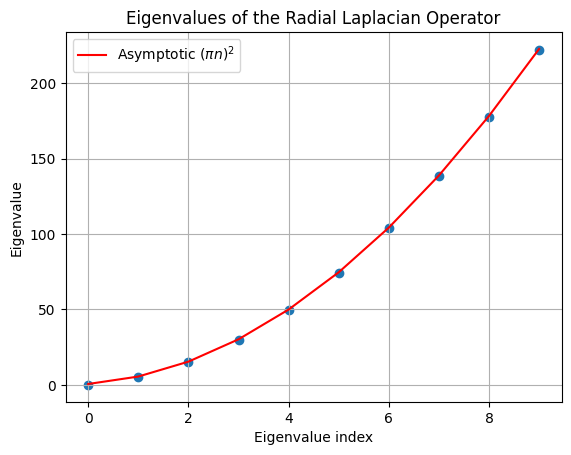

In [3]:
numerical_eigenvalues = [L.get_eigenvalue(i) for i in range(10)]
analytical_eigenvalues_asymptote = [((np.pi * (i+0.5))/(function_domain.length))**2 for i in range(10)]
plt.scatter(range(10), numerical_eigenvalues)
plt.plot(range(10), analytical_eigenvalues_asymptote, color='red', label='Asymptotic $(\pi n)^2$')
plt.legend()
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Radial Laplacian Operator')
plt.grid(True)
plt.show()

In [4]:
eigenfunctions_numerical = [L.get_eigenfunction(i) for i in range(3)]
analytical_eigenfunctions = [lambda x, n=n: np.sqrt(2/function_domain.length) * (np.sin((n+1) * np.pi * x / function_domain.length))/x for n in range(3)]
for i, ef in enumerate(eigenfunctions_numerical):
    x_vals = np.linspace(0, 1, 200)
    y_vals = ef.evaluate(x_vals)
    y_vals_analytical = analytical_eigenfunctions[i](x_vals)
    plt.plot(x_vals, y_vals, label=f'Numerical Eigenfunction {i+1}')
    plt.plot(x_vals, y_vals_analytical, linestyle='dashed', label=f'Analytical Eigenfunction {i+1}')
plt.legend()
plt.xlabel('x')
plt.ylabel('Eigenfunction value')
plt.title('Numerical and Analytical Eigenfunctions of the Radial Laplacian Operator')
plt.grid(True)
plt.show()

NotImplementedError: Radial Laplacian eigenfunctions for regularity-Neumann not yet implemented